# Functions definitions and library imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
import matplotlib as mpl

from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from scipy.stats import kstest, ks_2samp, anderson, chi2, anderson_ksamp

!pip install powerlaw 
import powerlaw

from scipy.stats import powerlaw as pw

import math
import csv
import sys
from time import time

from multiprocessing import Process, Queue, Value, Array

%matplotlib inline

THETA = math.pi/180

!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.0 MB/s eta 0:00:00
time: 3.92 ms (started: 2023-01-26 13:42:12 +00:00)


In [ ]:
def load_lines_from_xpp_file(File, offsetX=0, offsetY=0, k=0, segm_groups=[]):
  #File = "Gaivota2D.xpp"
  lines = []
  segm_groups = []
  points = []
  x0 = 0
  y0 = 0
  with open(File) as csv_file:
      points = []
      csv_reader = csv.reader(csv_file, delimiter='|')

      row_count = 0
      for row in csv_reader:
        for cell in row:
          if cell == 'FreeHand':
            planes_start = int(row[2])
            planes_end = int(row[2]) + int(row[1])
            break
        if 'planes_start' in locals():
            if row_count >= planes_start and row_count < planes_end:
              points = []

              row_values = row[6].split()


              for i in range(np.size(row_values)):
                if i > 2 and i < np.size(row_values):
                  points.append(float(row_values[i]))
              points = np.reshape(points, (int(np.size(points)/3), 3))
              points = np.asarray([points[:,0], points[:,2], -points[:,1]]).T
              #print(points)
        
              X = points[:,0]
              Y = -points[:,1]

              pca = PCA(n_components=1)
              data = np.transpose(np.asarray((X, Y)))
              pca.fit(data)
              X_pca = pca.transform(data)
              X_new = pca.inverse_transform(X_pca)

              # Obter os extremos horizontais
              p = np.where(X_new[:, 0] == np.amax(X_new[:, 0]))[0][0]
              q = np.where(X_new[:, 0] == np.amin(X_new[:, 0]))[0][0]

              # Verificar se a linha é vertical para calcular os extremos verticais
              if p == q:
                  p = np.where(X_new[:, 1] == np.amax(X_new[:, 1]))[0][0]
                  q = np.where(X_new[:, 1] == np.amin(X_new[:, 1]))[0][0]

              line = [X_new[p][0] + x0, X_new[p][1] + y0,
                      X_new[q][0] + x0, X_new[q][1] + y0]

              lines.append(line)
              #print(line)
        row_count +=1

  return lines

time: 6.81 ms (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
def load_lines_from_file(File, offsetX, offsetY, k=0, segm_groups=[]):

    # Read the file header and identify the drawn lines start and finish
    with open(File) as csv_file:
       csv_reader = csv.reader(csv_file, delimiter=' ')
       row_count = 0
       for row in csv_reader:
           for cell in row:
               if cell == 'FreeHand':
                   lines_start = int(row[1]) - 1
                   lines_end = int(row[2]) + int(row[1]) + 1
                   break

    lines = []
    segment = []
    with open(File) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=' ')
        row_count = 0
        segment = []
        for row in csv_reader:
            segment = []
            if row_count < lines_end and row_count > lines_start:
                collumn_count = 0
                for collumn in row:
                    # Ignore collumn indexes before line 3
                    if collumn_count > 2:
                        try:
                            # Get the value in each collumn and replace the
                            # commas for dots
                            value = float(collumn.replace(",", "."))
                            segment.append(value)
                        except ValueError:
                            print("", end="")
                    collumn_count = collumn_count + 1
                try:
                    segment = np.reshape(segment, (int(np.size(segment)/3), 3))
                except Exception as e:
                    print(e)
                    break
            
            segm_group_row = []

            # Get individual segments
            for i in range(0, np.shape(segment)[0]-1):
                lines.append([segment[i][0], -segment[i][2], segment[i+1][0],
                            -segment[i+1][2]])
                segm_group_row.append(k)
                k = k + 1

            if np.size(segm_group_row) > 0:
                segm_groups.append(segm_group_row)
            row_count = row_count + 1
            
    lines = np.reshape(lines, (np.shape(lines)[0], 4))

    minX = min(np.append(lines[:, 0], lines[:, 2]))
    minY = min(np.append(lines[:, 1], lines[:, 3]))
    maxX = max(np.append(lines[:, 0], lines[:, 2]))
    maxY = max(np.append(lines[:, 1], lines[:, 3]))

    for i in range(0, np.shape(lines)[0]):
        lines[i][0] = (lines[i][0]-minX+offsetX)
        lines[i][1] = (lines[i][1]-minY+offsetY)
        lines[i][2] = (lines[i][2]-minX+offsetX)
        lines[i][3] = (lines[i][3]-minY+offsetY)

    maxY = max(np.append(lines[:, 1], lines[:, 3]))
    maxX = max(np.append(lines[:, 0], lines[:, 2]))

    return lines, maxX, maxY, segm_groups

time: 9.52 ms (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
def regression_group_segments(segm_groups, lines, mode='canvas'):
    # Get regression line of group of segments
    regression_lines = []
    # lines0 = lines
    # lines = connected_lines
    for i in range(0, np.size(segm_groups)):
        X = []
        Y = []
        if mode == 'vertices':
            X.append(lines[segm_groups[i][0]][0])
            Y.append(lines[segm_groups[i][0]][1])
            for j in segm_groups[i]:
                X.append(lines[j][2])
                Y.append(lines[j][3])

            x0 = np.min(X)
            y0 = np.min(Y)
        else:
            # Get canvas extensions
            y = []
            x = []
            for j in segm_groups[i]:
                x.append(lines[j][0])
                x.append(lines[j][2])
                y.append(lines[j][1])
                y.append(lines[j][3])

            x0 = np.min(x)
            x1 = np.max(x)
            y0 = np.min(y)
            y1 = np.max(y)
            canvas = np.zeros((int(y1-y0+1), int(x1-x0+1)), np.uint8)
            # Draw the segments in the canvas
            for j in segm_groups[i]:
                canvas = cv2.line(canvas, (lines[j][0]-x0, lines[j][1]-y0),
                                  (lines[j][2]-x0, lines[j][3]-y0), 1)
            # Get the position of each pixel drawn in the canvas
            for m in range(0, np.shape(canvas)[0]):
                for n in range(0, np.shape(canvas)[1]):
                    if canvas[m][n] > 0:
                        Y.append(m)
                        X.append(n)

        pca = PCA(n_components=1)
        data = np.transpose(np.asarray((X, Y)))
        pca.fit(data)
        X_pca = pca.transform(data)
        X_new = pca.inverse_transform(X_pca)

        # Obter os extremos horizontais
        p = np.where(X_new[:, 0] == np.amax(X_new[:, 0]))[0][0]
        q = np.where(X_new[:, 0] == np.amin(X_new[:, 0]))[0][0]

        # Verificar se a linha é vertical para calcular os extremos verticais
        if p == q:
            p = np.where(X_new[:, 1] == np.amax(X_new[:, 1]))[0][0]
            q = np.where(X_new[:, 1] == np.amin(X_new[:, 1]))[0][0]

        line = [X_new[p][0] + x0, X_new[p][1] + y0,
                X_new[q][0] + x0, X_new[q][1] + y0]

        regression_lines.append(line)

    return np.reshape(regression_lines, (np.shape(regression_lines)[0], 4))

time: 7.46 ms (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
def compute_line_angles(lines):
    '''
    Get distance and angle of all lines regarding north

    Parameters
    ----------
    lines : Array of int64
        Array with structure [[Px Py Qx Qy] ... [Px Py Qx Qy]].

    Returns
    -------
    angles : Array of float64
        Array with angle and length for each line.

    '''
    # Get distance and angle of all lines regarding north
    n = np.shape(lines)[0]
    angles = np.zeros((n, 2), np.float64)
    for i in range(0, n):
        length = compute_distance(lines[i][0], lines[i][1], lines[i][2],
                                  lines[i][3])

        if lines[i][1] == lines[i][3]:
            angle = 90
        else:
            angle = (math.atan((lines[i][2]-lines[i][0])
                               / (lines[i][1]-lines[i][3])) / (THETA))

        if (angle < 0):
            angle = angle + 360
        if (angle > 180):
            angle = angle - 180
        if math.isnan(angle):
            angle = 0

        angles[i, 0] = np.uint(angle)
        angles[i, 1] = length
    return angles

def compute_distance(x0, y0, x1, y1):
    '''
    Compute the distance between two points.

    Parameters
    ----------
    x0 : TYPE
        DESCRIPTION.
    y0 : TYPE
        DESCRIPTION.
    x1 : TYPE
        DESCRIPTION.
    y1 : TYPE
        DESCRIPTION.

    Returns
    -------
    dist : float
        Distance in pixel size.
    '''

    #dist = math.sqrt(math.pow((x1 - x0), 2) + math.pow((y1 - y0), 2))
    dist = (math.pow((x1 - x0), 2) + math.pow((y1 - y0), 2))**.5
    return dist

time: 2.89 ms (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
def compute_fractal_dimension(data): # Rizzo, 2017. pag 19 Clauset, 2009
    alpha = 1 + np.size(data)*np.power(abs(np.sum(np.log(data/np.min(data)))), -1)
    return alpha
#alpha1 = compute_fractal_dimension(set1[:, 1])
#print(alpha1)
# TODO: Use SGD to get optmize value for fractal dimension alpha (D) 

time: 830 µs (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
def cost_function(data, alpha=None, x_min=None, metric='ks_t_HD'):

  P = np.copy(data[data >= x_min])

  uniform_data = np.linspace(x_min, np.max(P), np.size(P), dtype=np.float64)
  S = (uniform_data/np.min(uniform_data))**(-alpha+1)

  if metric == 'A2':
    cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
  if metric == 'HD':
    cost = hellinger(cdf(P), cdf(S))
  if metric == 'KS':
    cost = ks_2samp(cdf(P), cdf(S))[0]
  if metric == 'KS_t_HD':
    HD = hellinger(cdf(P), cdf(S))
    ks_t = kstest_hit_ratio2(P, alpha, x_min, max_iter=1000)
    cost = 100-ks_t + HD
  if metric == 'KS_t':
    ks_t = kstest_hit_ratio2(P, alpha, x_min, max_iter=1000)
    cost = 100-ks_t

  return cost


def sgd(data, alpha0, x_min0, learning_rate, momentum, change, fix_x_min, metric):
  # np.random.seed()
  alpha1 = alpha0
  x_min1 = x_min0  


  step = ((np.random.rand()*-2)+1)*learning_rate + momentum*change[0]
  alpha1 = alpha0 + step
  change[0] = step
  if alpha1 <= 1.1:
    # alpha1 = alpha0 - step
    # change[0] = -step
    alpha1 = 1.1
    change[0] = 0

  if fix_x_min == None:
    step = (((np.random.rand()*-2)+1)*learning_rate + momentum*change[1])
    x_min1 = x_min0 + step
    change[1] = step
    if x_min1 >= np.min(data) or x_min1 <= np.percentile(data, 75):
      x_min1 = x_min0 - step
      change[1] = -step
  else:
    x_min0 = fix_x_min
    x_min1 = fix_x_min

  custo0 = cost_function(data, alpha0, x_min0, metric)
  custo1 = cost_function(data, alpha1, x_min1, metric)

  alpha_temp = alpha0
  xmin_temp = x_min0

  if custo1 < custo0:
    alpha_temp = alpha1
    alpha0 = alpha1

    xmin_temp = x_min1
    x_min0 = x_min1
    custo0 = custo1

  return alpha0, x_min0, custo0, change 

def alpha_estimator(data,iters,learning_rate,n_seeds, momentum=0.8, fix_x_min=None, metric='ks_t_HD', multiprocessing=True):
    # cost_history = np.zeros((n_seeds, iters), dtype=np.float64)
    # alpha_history = np.zeros((n_seeds, iters), dtype=np.float64)
    # x_min_history = np.zeros((n_seeds, iters), dtype=np.float64)

    cost_history = Array('d', np.zeros((n_seeds*iters), dtype=np.float64))
    alpha_history = Array('d', np.zeros((n_seeds*iters), dtype=np.float64))
    x_min_history = Array('d', np.zeros((n_seeds*iters), dtype=np.float64))

    # change = np.zeros((n_seeds,2))

    data = np.sort(data)
    data = data.flatten()

    alpha0 = 1 + np.random.rand(n_seeds)*2
    # alpha0 = np.array(np.random.uniform(low=1, high=3, size=n_seeds), dtype=np.float64)
    # x_min0 = np.min(data) + np.random.rand(n_seeds)*np.percentile(data, 75)
    x_min0 = np.array(np.random.uniform(low=np.min(data), high=np.percentile(data, 75), size=n_seeds), dtype=np.float64)

    # Core function that call the SGD and save the individual results in global arrays
    def parallel_function(index, iters, cost_history, alpha_history, x_min_history, alpha0, x_min0, metric):
      temp_cost = []
      temp_alpha = []
      temp_xmin = []

      index = int(index)

      change = [0,0]
      
      for i in range(iters):
        alpha0, x_min0, custo0, change = sgd(data, alpha0,x_min0,learning_rate,
                                             momentum, change, fix_x_min, metric)
        cost_history[(index*iters)+i] = custo0
        alpha_history[(index*iters)+i] = alpha0
        x_min_history[(index*iters)+i] = x_min0

    if multiprocessing:
      processes = list()
      for index in range(n_seeds):
          p = Process(target=parallel_function, args=(index,
                                                      iters,
                                                      cost_history,
                                                      alpha_history,
                                                      x_min_history,
                                                      alpha0[index],
                                                      x_min0[index],
                                                      metric))
          processes.append(p)
          p.start()

      for p in processes:
          p.join()
    else:
      for index in range(n_seeds):
        parallel_function(index, iters, cost_history, alpha_history, x_min_history,
                          alpha0[index], x_min0[index], metric)



    alpha_history = np.asarray(alpha_history).flatten()
    x_min_history = np.asarray(x_min_history).flatten()
    cost_history = np.asarray(cost_history).flatten()

    alpha_sgd = np.asarray(alpha_history)[np.argsort(cost_history)][0]
    x_min_sgd = np.asarray(x_min_history)[np.argsort(cost_history)][0]


    return alpha_sgd, x_min_sgd, cost_history, alpha_history, x_min_history

time: 8.63 ms (started: 2023-01-25 18:57:41 +00:00)


In [ ]:
def inverse_cumulative_powerlaw(bins, alpha, cumulative=True, x_min=None):
    # bins = rescale(bins, (x_min, 1))

    # bins = 1 - bins

    if x_min == None:
      x_min = np.min(bins)
    # power_law = ((alpha-1)/x_min) * (bins/x_min) ** -alpha

    power_law = (bins/x_min)**(-alpha+1)
    if cumulative is True:
        power_law = power_law.cumsum()
        power_law /= power_law[-1] 
    return power_law

def probability_plot(data, distribution_type, title, xlabel, alpha=None, A=None, x_min=None, plot=True, filename=None):
    X = np.flip(np.sort(data))
    

    if x_min != None:
      X = X[np.where(X > x_min)]
    if x_min == None:
      x_min = 1
      X = X[np.where(X > 1)]

    uniform_data = np.linspace(x_min, np.max(X), np.size(X), dtype=np.float64)
    P = 1-(uniform_data/x_min)**(-alpha+1)
    
    x_ = 1-X/np.max(X)

    ks = np.max(np.absolute(P - x_))

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(x_, P)
    ax[1].hist([Y_, X], cumulative=True, density=True, histtype='step', bins=np.size(X))
    ax[1].plot(P, label="Power law")
    ax[1].plot(x_, label="Data")
    ax[1].legend(loc='upper right',fontsize=12)
    fig.show()


    # Ajustamento de uma CDF de lei de potência contra valores de atributos em X
    Y = np.reshape(P, (np.size(P), 1))
    A = np.vstack([X, np.ones(np.size(X))]).T
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]

    r2 = r2_score(Y, m*X+c)

    print(ks)

    plot_canvas=None

    if plot==True:
      fig, ax = plt.subplots(figsize=(10, 7))
      ax.grid(True)
      # ax.plot(X, 'bx', label="Data")
      # ax.plot(X, P, 'bx', label="Data")
      # ax.plot(X, (m*X+c), 'r--', label="Linear fitting")
      ax.plot([], [], ' ', label="R² score: " + str("%.4f" % r2))
      ax.plot([], [], ' ', label="K-S: " + str("%.4f" % ks))
      ax.legend(loc='upper right',fontsize=20)
      ax.set_yscale('log')
      ax.set_xscale('log')

      ax.set_title(title,fontsize=20)
      ax.set_xlabel(xlabel,fontsize=20)
      ax.set_ylabel("CDF P(x)",fontsize=20)
      plt.xticks(fontsize=18)
      plt.yticks(fontsize=18)
      
      fig.canvas.draw()

      # # Now we can save it to a numpy array.
      plot_canvas = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
      plot_canvas = plot_canvas.reshape(fig.canvas.get_width_height()[::-1] + (3,))

      if filename is not None:
        plt.savefig(filename)

    return r2, ks, plot_canvas

time: 9.09 ms (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
def rosechart(angles_, weights=None, filename=None):
  bin_edges = np.arange(-5, 366, 10)
  number_of_strikes, bin_edges = np.histogram(angles_, bin_edges, weights)

  number_of_strikes[0] += number_of_strikes[-1]
  half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
  two_halves = np.concatenate([half, half])

  fig = plt.figure() # figsize=(10, 10)
  ax = fig.add_subplot(111, projection='polar')
  ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves,
          width=np.deg2rad(10), bottom=0.0, color='gray', edgecolor='lightgray')
  ax.set_theta_zero_location('N')
  ax.set_theta_direction(-1)
  ax.set_thetagrids(np.arange(0, 360, 90), labels=['','','',''])
  #ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
  # ax.set_rgrids(np.arange(1, two_halves.max()+1, 2),angle=0,weight='black')
  ax.set_title("n = "+str(np.size(angles_)), y=1, fontsize=14)
  ax.set_yticks([])
  fig.canvas.draw()

  # Save it to a numpy array.
  plot = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  plot = plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

  if filename is not None:
    plt.savefig(filename)

  #plt.show()
  return plot

time: 3.8 ms (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
def kstest_hit_ratio2(X, alpha=1.1, xmin=1, max_iter=2500, ref=0.05, mode='pvalue', synthetic_data=None):
  # X = np.sort(X)
  if type(synthetic_data) == type(None):
    np.random.seed(3)
    r = np.array(np.random.uniform(0.0, 1.0, size=(max_iter, np.size(X))), dtype=np.float64)
    power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009
    g = np.sort(power(r), axis=1)

  temp_X = np.reshape(np.tile(X, max_iter), (max_iter, np.size(X)))
  test = np.asarray(list(map(kstest, temp_X, g)))

  if mode=='pvalue':
    return (np.size(np.where(test[:,1] > ref))/max_iter)*100
  else:
    return (np.size(np.where(test[:,0] > ref))/max_iter)*100


def hellinger (p, q):
  H = (1/np.sqrt(2))*np.sqrt(np.sum(np.power((np.sqrt(p)-np.sqrt(q)), 2)))
  return H

time: 4.11 ms (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
def kstest_hit_ratio(X, alpha=1.1, xmin=1, max_iter=2500):
  # X = np.sort(X)

  testresult = 0
  for i in range(0, max_iter):
    r = np.random.uniform(0.0, 1.0, size=np.size(X))
    power = xmin*np.power((1-r),(-1/(alpha-1))) # Equation D.4 from Clauset, 2009
    g = np.sort(power)

    h_value, p_value = kstest(X,g)

    if p_value > 0.05:
      testresult += 1

  ks_results = testresult/max_iter
  return ks_results*100

def ks_distance(X, alpha=1.1, xmin=1):
  uniform_data = np.linspace(xmin, np.max(X), np.size(X), dtype=np.float64)
  P = (uniform_data/np.min(uniform_data))**(-alpha+1)

  X = np.flip(np.sort(X))
  x_ = X/np.max(X)

  D = np.max(np.absolute(P - x_))
  RMSE = np.sqrt(sum(np.power((P - x_), 2)))

  return D, RMSE

# ref: https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509

# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)

def powerlaw_fitting(X=[], alpha_=1.1, xmin_=1, plot=True, ks_evaluation=False, filename=None):

  X = X[X > xmin_]
  X = X.flatten()
  X = np.sort(X)
  X = np.flip(X)

  uniform_data = np.linspace(xmin_, np.max(X), np.size(X), dtype=np.float64)
  Y = 1-(uniform_data/xmin_)**(-alpha_+1)  # Equation 2.6 from Clauset, 2009
  # Y = generate_powerlaw_data(alpha, xmin_, np.size(X), random=False)

  Y_ = np.copy(Y)
  Y = Y.cumsum()
  Y = Y/np.max(Y)

  pars, cov = curve_fit(f=power_law, xdata=X, ydata=Y, p0=[0, 0], bounds=(-np.inf, np.inf))
  r2 = r2_score(Y, power_law(X, *pars))

  ks_t = 0
  if ks_evaluation == True:
    ks_t = kstest_hit_ratio2(X, alpha_, xmin_)

  ks_d = ks_2samp(cdf(X), Y_)[0]
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]
  HD = hellinger(cdf(X), Y_)


  if plot==True:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.grid(True)
    # ax.plot(X, Y, 'bx', label="Data")
    ax.plot(X, Y, '.', color='#00b3b3', label='Data')

    ax.plot(X, power_law(X, *pars), linewidth=2, linestyle='--', color='black', label='Power-law fitting')
    ax.plot([], [], ' ', label=r'$\hat\alpha$: ' + str("%.1f" % alpha_))
    ax.plot([], [], ' ', label=r'$x_{min}$: ' + str("%.1f" % xmin_))
    
    ax.legend(loc='upper right',fontsize=12)
    
    # ax.set_title(r'$\alpha$: ' + str("%.1f" % alpha) + r'     $x_{min}$: ' + str("%.1f" % xmin), fontsize=14)

    ax.set_xlabel(r'$x$', fontsize=14)
    ax.set_ylabel(r'$P(x)$', fontsize=14)

    ax.set_yscale('log')
    ax.set_xscale('log')

    # Edit the major and minor ticks of the x and y axes
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

    # Edit the major and minor tick locations of x and y axes
    ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
    ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))

    if filename is not None:
      plt.savefig(filename)

    plt.show()

  return r2, ks_t, ks_d, A2, HD

time: 8 ms (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
def generate_powerlaw_data(alpha, xmin, size, random=False):
  if random == True:
    x =np.random.uniform(0.0, 1.0, size=size)
  else:
    x = np.linspace(pw.ppf(0.01, alpha),
                    pw.ppf(0.99, alpha), size)
    
  P = xmin*np.power((1-x),(-1/(alpha-1)))
  P = np.sort(P)
  return P

time: 2.2 ms (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
# def bhattacharyya(a, b):
#     """ Bhattacharyya distance between distributions (lists of floats). """
#     if not len(a) == len(b):
#         raise ValueError("a and b must be of the same size")
#     return -math.log(sum((math.sqrt(u * w) for u, w in zip(a, b))))

# def hellinger(p, q):
#   H = np.sqrt((1-bhattacharyya(p, q)))
#   return H

time: 540 µs (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
def plot_history(n_seeds, cost_history, max_iterations, filename=None):
  fig, ax = plt.subplots(figsize=(6, 4))
  for i in range(n_seeds):
    ax.plot(cost_history[i*max_iterations:i*max_iterations + max_iterations])
  ax.set_xlabel('Iterations', fontsize=14)
  ax.set_ylabel('Cost', fontsize=14)

  if filename is not None:
    plt.savefig(filename)

  plt.show()

time: 1.92 ms (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
def power_law_fitting_deluca(data):
  distances = []
  alphas = []

  data = np.sort(data)

  for i in range(int(np.size(data)*0.75)):

    temp_data = data[i:]
    x = data[i]
    if np.size(temp_data) > 2:
      alpha_mle = compute_fractal_dimension(temp_data)
      alphas.append(alpha_mle)


      x_ = np.linspace(pw.ppf(0.01, alpha_mle),
                    pw.ppf(0.99, alpha_mle), np.size(temp_data))

      P = x*np.power((1-x_),(-1/(alpha_mle-1)))
      P = P/np.max(P)

      S = temp_data/np.max(temp_data)
      D = ks_2samp(S, P)[0]

      ks_t = kstest_hit_ratio2(data, alpha_mle, x, 1000, D, 'distance')
      distances.append(ks_t)

  xmin = data[np.where(distances == np.max(distances))][0]
  alpha = np.asarray(alphas)[np.where(distances == np.max(distances))][0]

  print(alpha, xmin)

  return alpha, xmin

time: 4.21 ms (started: 2023-01-25 18:38:18 +00:00)


In [ ]:
def pdf(data):
  return np.histogram(data, np.size(data), density=True)[0]

def cdf(data):
  # return np.histogram(data, np.size(data), density=False)[0]
  H,X1 = np.histogram(data, np.size(data), density = True )
  dx = X1[1] - X1[0]
  F1 = np.cumsum(H)*dx
  return F1

time: 1.7 ms (started: 2023-01-25 18:38:18 +00:00)


# Loading FreeHand data from Mosis XP

In [ ]:
# lines, maxX, maxY, segm_groups = load_lines_from_file('Rosario.data', 0, 0, 0, [])
# regression_lines = regression_group_segments(segm_groups, np.uint(lines), mode='vertices')
# image = np.full((int(maxY), int(maxX), 3), 255, dtype=np.uint8)
# image = draw_lines(image, regression_lines)
# plt.figure(1, (10,10))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

time: 1.01 ms (started: 2023-01-25 18:47:41 +00:00)


In [ ]:
lines = load_lines_from_xpp_file('Gaivota2D.xpp', 0, 0, 0, [])
segm_group_angles = compute_line_angles(lines)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: 

time: 756 ms (started: 2023-01-25 18:47:42 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_pca.py:499: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


<ipython-input-10-f27ef2f619b0>:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  plot = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


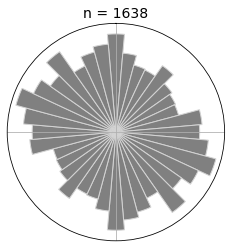

time: 489 ms (started: 2023-01-25 18:47:43 +00:00)


In [ ]:
aux = segm_group_angles[np.where(segm_group_angles[:, 1] >0)]
rosechart_plot = rosechart(aux[:, 0], filename='rosechart.pdf')
#cv2.imwrite('rosechart.png', cv2.cvtColor(rosechart_plot, cv2.COLOR_RGB2BGR))

<ipython-input-10-f27ef2f619b0>:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  plot = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


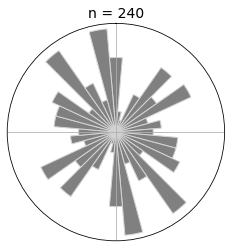

time: 378 ms (started: 2023-01-25 18:47:43 +00:00)


In [ ]:
aux = segm_group_angles[np.where(segm_group_angles[:, 1] > 10)]
rosechart_plot = rosechart(aux[:, 0],  filename='rosechart_10.pdf')
# cv2.imwrite('rosechart_10.png', cv2.cvtColor(rosechart_plot, cv2.COLOR_RGB2BGR))

# Tests with synthetic data

## SGD default settings

In [ ]:
learning_rate = 0.05
max_iterations = 500
momentum=0.3
n_seeds = 10

time: 945 µs (started: 2023-01-21 14:33:33 +00:00)


## SGD cost function evaluation

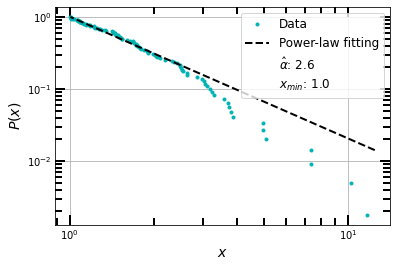

0.9910063289604277 98.08 0.18 0.42113671021137167 0.31104337960043726
>>> A2 cost function


<ipython-input-36-7b3cdce06ad2>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-36-7b3cdce06ad2>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-36-7b3cdce06ad2>:17: UserWarning: p-value capped: true value larger than 0.25
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-36-7b3cdce06ad2>:17: UserWarning: p-value capped: true value larger than 0.25
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-36-7b3cdce06ad2>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-36-7b3cdce06ad2>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-36-7b3cdce06ad2>:17: UserWarning: p-value capped: true value 

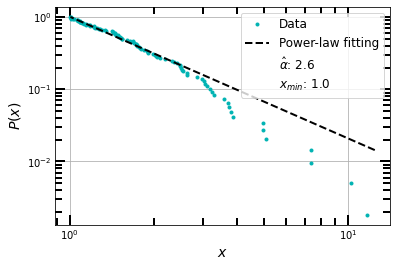

0.990987312047146 96.39999999999999 0.13 0.2997909401176378 0.3072281325042336


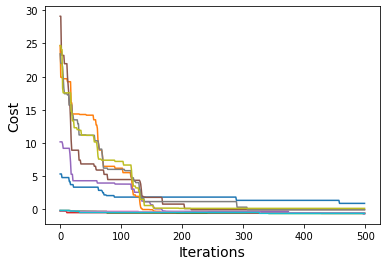

>>> HD cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


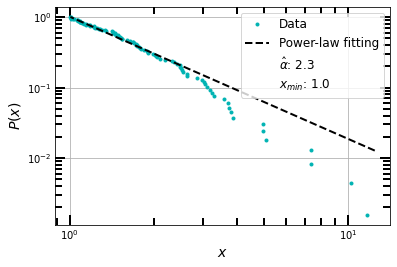

0.9911664601472796 98.24000000000001 0.45 15.8561179989377 0.3816267141661264


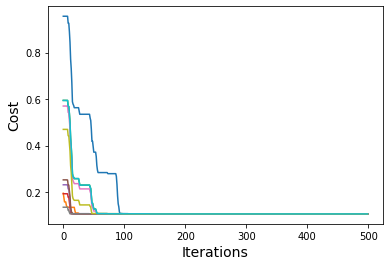

>>> KS cost function


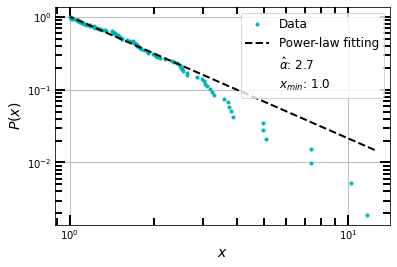

0.9909596529411593 91.28 0.21 3.1572940679318213 0.30591212348133945


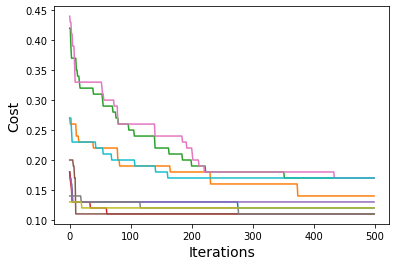

>>> KS_t cost function


<ipython-input-12-df8c52e79590>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009
<ipython-input-12-df8c52e79590>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009
<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


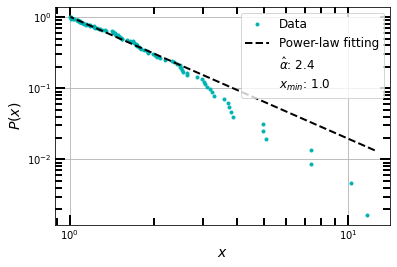

0.9910787618046897 99.36 0.39 6.628698856684456 0.3368309420552962


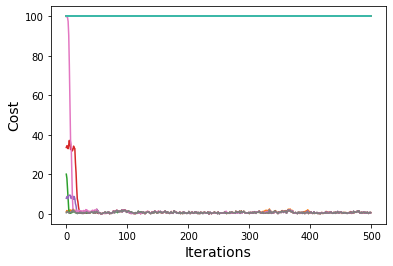

>>> KS_t_HD cost function


<ipython-input-12-df8c52e79590>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009
<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


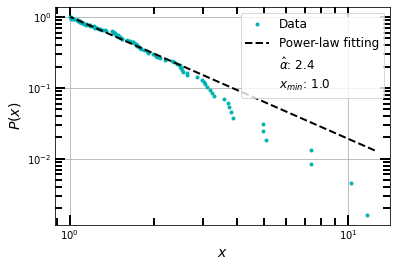

0.9911143837908989 99.44 0.45 12.013035452334282 0.3536970430760079


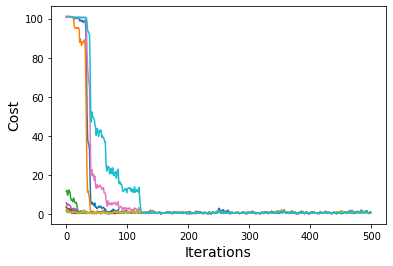

time: 53min 6s (started: 2023-01-17 17:27:27 +00:00)


In [ ]:
## Generating synthetic distribution
alpha = 2.5
xmin = 1
# np.random.seed(0)
r = np.random.uniform(0.0, 1.0, size=100)
power = xmin*(1-r)**(-1/(alpha-1)) # Equation D.4 from Clauset, 2009
g = np.sort(power)


metric_results = []
fit = powerlaw.Fit(g, xmin=1)
xmin = fit.xmin
alpha = fit.power_law.alpha
r2, ks_t, ks_d, A2, HD = powerlaw_fitting(g, alpha, xmin, ks_evaluation=True)
metric_results.append([alpha, r2, ks_t, ks_d, A2, HD])
print(r2, ks_t, ks_d, A2, HD)


for metric in ['A2', 'HD', 'KS', 'KS_t', 'KS_t_HD']:

    print('>>> ' + metric + ' cost function')
    results = alpha_estimator(g, max_iterations, learning_rate, n_seeds,
                              fix_x_min=xmin, metric = metric)
    alpha_sgd, x_min_sgd, cost_history, alpha_history, x_min_history = results

    r2, ks_t, ks_d, A2, HD = powerlaw_fitting(g, alpha_sgd, x_min_sgd, ks_evaluation=True, filename=metric+'_fitting.pdf')
    metric_results.append([alpha_sgd, r2, ks_t, ks_d, A2, HD])
    print(r2, ks_t, ks_d, A2, HD)
    plot_history(n_seeds, cost_history, max_iterations, metric+'_history.pdf')



In [ ]:
#r2, ks_t, ks_d, A2, HD

metric_text = ['MLE', 'SGD A2', 'SGD HD', 'SGD K-S d', 'SGD K-S t', 'SGD K-S t+HD']

for i in range(6):
  print(metric_text[i], end=' & ')
  for j in range(np.size(metric_results[i])):
    if j != np.size(metric_results[i])-1:
      print(str("%.4f" % metric_results[i][j]), end=' & ')
    else:
      print(str("%.4f" % metric_results[i][j]), end=' \\\ \\hline \n ')

MLE & 2.5630 & 0.9910 & 98.0800 & 0.1800 & 0.4211 & 0.3110 \\ \hline 
 SGD A2 & 2.6148 & 0.9910 & 96.4000 & 0.1300 & 0.2998 & 0.3072 \\ \hline 
 SGD HD & 2.2901 & 0.9912 & 98.2400 & 0.4500 & 15.8561 & 0.3816 \\ \hline 
 SGD K-S d & 2.7147 & 0.9910 & 91.2800 & 0.2100 & 3.1573 & 0.3059 \\ \hline 
 SGD K-S t & 2.4170 & 0.9911 & 99.3600 & 0.3900 & 6.6287 & 0.3368 \\ \hline 
 SGD K-S t+HD & 2.3611 & 0.9911 & 99.4400 & 0.4500 & 12.0130 & 0.3537 \\ \hline 
 time: 29 ms (started: 2023-01-17 20:28:23 +00:00)


### Evaluating cost functions 10 times to obtain average values

In [ ]:
learning_rate = 0.05
max_iterations = 500
momentum=0.3
n_seeds = 10



n = 10
metrics = ['A2', 'HD', 'KS', 'KS_t']
metric_results = np.zeros((n, 5, 6))

alpha = 2.5
xmin = 1

for i in range(n):

  j = 0
  
  np.random.seed(i)
  r = np.random.uniform(0.0, 1.0, size=100)
  power = xmin*(1-r)**(-1/(alpha-1)) # Equation D.4 from Clauset, 2009
  g = np.sort(power)

  fit = powerlaw.Fit(g, xmin=1)
  xmin = fit.xmin
  alpha_mle = fit.power_law.alpha
  r2, ks_t, ks_d, A2, HD = powerlaw_fitting(g, alpha, xmin, ks_evaluation=True, plot=False)
  metric_results[i, j] = alpha_mle, r2, ks_t, ks_d, A2, HD
  print(alpha_mle, r2, ks_t, ks_d, A2, HD)


  for metric in metrics: # ['A2', 'HD', 'KS', 'KS_t', 'KS_t_HD']
      j += 1
      print('>>> ' + metric + ' cost function')
      results = alpha_estimator(g, max_iterations, learning_rate, n_seeds,
                                fix_x_min=xmin, metric = metric)
      alpha_sgd, x_min_sgd, cost_history, alpha_history, x_min_history = results

      r2, ks_t, ks_d, A2, HD = powerlaw_fitting(g, alpha_sgd, x_min_sgd, ks_evaluation=True, plot=False)
      metric_results[i, j] = alpha_sgd, r2, ks_t, ks_d, A2, HD
      print(alpha_sgd, r2, ks_t, ks_d, A2, HD)
      # plot_history(n_seeds, cost_history, max_iterations, metric+'_history.pdf')



2.632833604818021 0.9947123748919959 99.32 0.36 3.5044868013576176 0.40577146412075904
>>> A2 cost function


<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value 

2.432141399882932 0.9946997719188603 98.16 0.36 3.1128801670706556 0.416264096483814
>>> HD cost function
2.3773969625218636 0.9946908634143792 94.28 0.36 3.3226243116053933 0.4270607719763211
>>> KS cost function
2.351925457380645 0.9946871412638333 92.92 0.36 3.7165291429698124 0.43289202381211006
>>> KS_t cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.656329125919365 0.9947467425873965 99.72 0.27 7.142536841522857 0.3910864581437544
2.5818788426188135 0.9970103830166304 99.68 0.53 7.448939387538666 0.38562150794813194
>>> A2 cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smal

2.604781487848567 0.9970086345106222 99.6 0.4 6.201219688140745 0.3774162190356269
>>> HD cost function
2.3249615878115395 0.99701841940526 96.52 0.53 11.801303623462083 0.41532404014782465
>>> KS cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.97974438082479 0.9970151665105564 90.03999999999999 0.5 31.94243646496285 0.37881756477001327
>>> KS_t cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.6043600666093094 0.997008637604006 99.83999999999999 0.4 6.201219688140745 0.37743843295807655
2.744492764802348 0.9895134621023817 87.64 0.28 12.310715703510963 0.44522073420177427
>>> A2 cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smal

2.7904678374277427 0.9897800835427712 98.72 0.57 39.24231121611872 0.41947794843151626
>>> HD cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.3966182495265262 0.9894105223906987 71.28 0.41 5.828046829633513 0.46119056022596167
>>> KS cost function
3.066346932057013 0.9899935158210672 92.2 0.7 58.400128371487725 0.4097177962877166
>>> KS_t cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]
<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.7742132524805827 0.9897662359174858 98.8 0.56 38.03111930097953 0.420393338835671
2.7491013003222315 0.9920307337214704 94.12 0.41 10.532854079941972 0.3327445117597287
>>> A2 cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smal

3.4723121713968625 0.9922815997321506 39.12 0.53 32.47683087702988 0.3024925931642677
>>> HD cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.4265074337622647 0.9920382245705869 87.96000000000001 0.49 15.410172298507897 0.36055223659406116
>>> KS cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.630201685959081 0.9920303127661438 98.72 0.32 2.179094364789597 0.2969644301906163
>>> KS_t cost function
2.6986567496270357 0.9920360177405186 98.92 0.22 0.42957604588268206 0.2843274250468296
2.483814582625407 0.9875913661992964 96.28 0.23 0.7124393846379822 0.3036913943801444
>>> A2 cost function


<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larger than 0.25
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larger than 0.25
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larger 

2.632813489329458 0.987716082028822 88.8 0.23 1.7556335195587067 0.29888931096762833
>>> HD cost function
2.2484662924935015 0.9873699417764835 93.96 0.4 11.315895890939133 0.36266061617269263
>>> KS cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.264971145981115 0.9873835402833536 94.52000000000001 0.4 10.243559175644426 0.3561656935877054
>>> KS_t cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.412484462560419 0.9875114129359195 97.11999999999999 0.31 3.014491005635231 0.31540555774284834
2.5044237848374706 0.9975074046423706 99.8 0.27 1.0135964771578285 0.36330119140023087
>>> A2 cost function


<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larger than 0.25
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larg

2.292329419637085 0.9975611869360449 94.96 0.48 9.8277720074547 0.39703702020234827
>>> HD cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.2821863180778004 0.9975638450845777 94.28 0.48 10.05324258280567 0.39983540151355984
>>> KS cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.665205693406853 0.9974656442943216 99.32 0.24 4.5352263108742 0.3588467339270313
>>> KS_t cost function
2.594660925432552 0.9974833539475635 99.88 0.17 2.2325328427396403 0.35904492479499006
2.4233825078867324 0.9915617287881889 97.64 0.34 15.879017696485029 0.39493627633152334
>>> A2 cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larger than 0.25
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larger t

2.4864688539563824 0.9915548448862627 97.76 0.33 14.383648745651982 0.3957203424127203
>>> HD cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.2256807729313404 0.9914519334073406 95.67999999999999 0.31 3.09690317491393 0.4289580167384923
>>> KS cost function
2.2768162484369663 0.9914666143136588 98.2 0.31 2.9877229724260728 0.41898261377927737
>>> KS_t cost function
2.3741406164592633 0.9915026990022705 99.03999999999999 0.25 4.342320039456961 0.40520834544305895
2.5500350938439302 0.9869276640872584 97.56 0.41 6.786552365427421 0.2650766375105447
>>> A2 cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larger than 0.25
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larger t

2.5770709994534116 0.9870036970892 94.8 0.34 3.96066541939761 0.25462428513323
>>> HD cost function
2.246633095539198 0.9866857660755436 93.12 0.5 16.702113503472745 0.35790911725384555
>>> KS cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.7858543706711094 0.9872112226093556 79.88 0.29 1.8589473161222327 0.2555156420310117
>>> KS_t cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.440210598161624 0.9868692463664763 98.36 0.41 8.119395288037948 0.27842470431345107
2.509363455228458 0.990900442604728 99.2 0.24 3.2492634249168955 0.3474641556555279
>>> A2 cost function


<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larger than 0.25
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larger than 0.25
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larger than 0.25
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller t

2.433857556741546 0.9908418424285397 99.08 0.19 1.445572047739273 0.35563361171919006
>>> HD cost function
2.3021368269732974 0.9907289074247942 95.76 0.26 2.469074369327372 0.38255295353629604
>>> KS cost function
2.3034286567111817 0.9907299819019141 96.08 0.26 2.444465508959644 0.38220742818015113
>>> KS_t cost function
2.454231963531872 0.9908597945499383 99.44 0.2 1.9002909500062115 0.3527870689540696
2.6523420807823364 0.9951612476425233 98.2 0.34 2.357197703018535 0.376602613550356
>>> A2 cost function


<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value capped: true value larger than 0.25
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value smaller than 0.001
  cost = anderson_ksamp([cdf(P), cdf(S)], midrank=True)[0]
<ipython-input-7-979a3af64391>:17: UserWarning: p-value floored: true value sma

2.8793502857838513 0.9952928797442779 96.6 0.28 10.461064323706186 0.34776671283951577
>>> HD cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.393971717629908 0.9951267537027984 94.88 0.34 5.221686807344477 0.4014380029021415
>>> KS cost function
3.0213529899486 0.995342120582067 89.88000000000001 0.38 19.466456387530176 0.3507332661615591
>>> KS_t cost function


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.644924784591982 0.9952107070575104 99.6 0.34 2.5058127821834595 0.35673681745423014
time: 3h 57min 12s (started: 2023-01-19 13:53:54 +00:00)


In [ ]:
print(metric_results)

[[[ 2.6328336   0.99471237 99.32        0.36        3.5044868
    0.40577146]
  [ 2.4321414   0.99469977 98.16        0.36        3.11288017
    0.4162641 ]
  [ 2.37739696  0.99469086 94.28        0.36        3.32262431
    0.42706077]
  [ 2.35192546  0.99468714 92.92        0.36        3.71652914
    0.43289202]
  [ 2.65632913  0.99474674 99.72        0.27        7.14253684
    0.39108646]]

 [[ 2.58187884  0.99701038 99.68        0.53        7.44893939
    0.38562151]
  [ 2.60478149  0.99700863 99.6         0.4         6.20121969
    0.37741622]
  [ 2.32496159  0.99701842 96.52        0.53       11.80130362
    0.41532404]
  [ 2.97974438  0.99701517 90.04        0.5        31.94243646
    0.37881756]
  [ 2.60436007  0.99700864 99.84        0.4         6.20121969
    0.37743843]]

 [[ 2.74449276  0.98951346 87.64        0.28       12.3107157
    0.44522073]
  [ 2.79046784  0.98978008 98.72        0.57       39.24231122
    0.41947795]
  [ 2.39661825  0.98941052 71.28        0.41      

In [ ]:
mean_results = np.mean(metric_results, axis=0)

metric_text = ['MLE', 'SGD A2', 'SGD HD', 'SGD K-S d', 'SGD K-S t']

for i in range(5):
  print(metric_text[i], end=' & ')
  for j in range(np.size(mean_results[i])):
    if j != np.size(mean_results[i])-1:
      print(str("%.3f" % mean_results[i][j]), end=' & ')
    else:
      print(str("%.3f" % mean_results[i][j]), end=' \\\ \\hline \n ')

MLE & 2.583 & 0.992 & 96.944 & 0.341 & 6.380 & 0.362 \\ \hline 
 SGD A2 & 2.660 & 0.992 & 90.760 & 0.371 & 12.287 & 0.357 \\ \hline 
 SGD HD & 2.322 & 0.992 & 91.772 & 0.408 & 8.522 & 0.400 \\ \hline 
 SGD K-S d & 2.635 & 0.992 & 93.176 & 0.376 & 13.777 & 0.364 \\ \hline 
 SGD K-S t & 2.565 & 0.992 & 99.072 & 0.313 & 7.392 & 0.354 \\ \hline 
 time: 23.3 ms (started: 2023-01-19 18:49:00 +00:00)


### Evaluating optimizations in execution time

In [ ]:
learning_rate = 0.05
max_iterations = 100
momentum=0.3
n_seeds = 10


set1 = np.where((segm_group_angles[:, 0] <= 20) | (segm_group_angles[:, 0] > 160) & (segm_group_angles[:, 1] > 0),
         segm_group_angles[:, 0], None)

set1 = segm_group_angles[set1 != np.array(None)]


time_singleprocessing = []
time_multiprocessing = []

for i in range(1,10):
  start_time = time()
  results = alpha_estimator(set1[:, 1], max_iterations, learning_rate, i,
                            fix_x_min=None, metric='KS_t', multiprocessing=False)
  execution_time = time() - start_time
  print(str(i) + ' Single ' + str(execution_time))
  time_singleprocessing.append(execution_time)

  start_time = time()
  results = alpha_estimator(set1[:, 1], max_iterations, learning_rate, i,
                            fix_x_min=None, metric='KS_t', multiprocessing=True)
  execution_time = time() - start_time
  print(str(i) + ' Multi ' + str(execution_time))
  time_multiprocessing.append(execution_time)


alpha_sgd, x_min_sgd, cost_history, alpha_history, x_min_history = results

powerlaw_fitting(set1[:, 1], alpha_sgd, x_min_sgd, ks_evaluation=True)

for i in range(n_seeds):
  plt.plot(cost_history[i*max_iterations:i*max_iterations + max_iterations])



In [ ]:
for i in range(n_seeds):
  plt.plot(cost_history[i*max_iterations:i*max_iterations + max_iterations])
  index = (i)*max_iterations + max_iterations-1
  print(alpha_history[index], x_min_history[index], cost_history[index])

<ipython-input-50-39229aba5fde>:10: RuntimeWarning: divide by zero encountered in log10
  c=np.log10(cost_history),


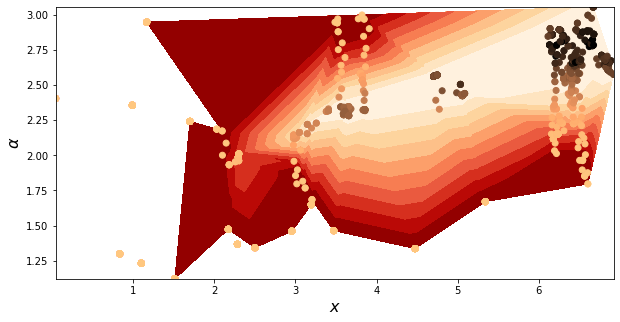

time: 215 ms (started: 2023-01-20 23:50:12 +00:00)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.tricontourf(x_min_history,
             alpha_history,
             cost_history, 10,
             cmap='OrRd')

ax.scatter(x_min_history,
            alpha_history,
            c=np.log10(cost_history),
          #  c='k',
            cmap='copper')

# for i in range(n_seeds):
#   ax.plot(x_min_history[i*max_iterations:i*max_iterations + max_iterations],
#           alpha_history[i*max_iterations:i*max_iterations + max_iterations],
#           c='gray')

ax.set_xlabel(r'$x$',fontsize=16)
ax.set_ylabel(r"$\alpha$",fontsize=16)

plt.show()

### Evaluation of kstest optimizations

In [ ]:
data = X[X > xmin]
data = data.flatten()
for i in range(0, 100):
  ks_t = kstest_hit_ratio(data, 2, xmin, max_iter=2500)

time: 36.7 s (started: 2022-11-11 19:11:46 +00:00)


In [ ]:
data = X[X > xmin]
data = data.flatten()
for i in range(0, 100):
  ks_t = kstest_hit_ratio2(data, 2, xmin, max_iter=2500)

time: 37.3 s (started: 2022-11-09 20:23:20 +00:00)


## Estimating attribute distributions of synthetic data

In [ ]:
learning_rate = 0.05
max_iterations = 50
momentum=0.3
n_seeds = 20

time: 1.03 ms (started: 2023-01-21 13:03:04 +00:00)


In [ ]:
n = 10
statistics_mle = []
statistics_sgd = []

method = 'KS_t'

seed_random = 0
for alpha in [2.5]: # 1.7, 2.0, 2.3, 2.5
    for xmin in [1]:
        for i in range(0, n):
            np.random.seed(seed_random)
            r = np.random.uniform(0.01, 1.0, size=100)
            power = xmin*(1-r)**(-1/(alpha-1)) # Equation D.4 from Clauset, 2009
            g = np.sort(power)
            # g = generate_powerlaw_data(alpha, xmin, 100, random=True)
            
            fit = powerlaw.Fit(g, xmin=xmin)
            xmin_mle = fit.xmin
            alpha_mle = fit.power_law.alpha
            r2, ks_t, ks_d, A2, HD = powerlaw_fitting(g, alpha_mle, xmin_mle, ks_evaluation=True, plot=False)
            statistics_mle.append((alpha_mle, xmin_mle, r2, ks_t, ks_d, A2, HD))
            print(alpha_mle, xmin_mle)
            print((r2, ks_t, ks_d, A2, HD))

            alpha_sgd, x_min_sgd, cost_history, alpha_history, x_min_history = alpha_estimator(g, max_iterations, learning_rate, n_seeds, fix_x_min=1, metric=method)
            r2, ks_t, ks_d, A2, HD = powerlaw_fitting(g, alpha_sgd, xmin, ks_evaluation=True, plot=False)
            statistics_sgd.append((alpha_sgd, x_min_sgd, r2, ks_t, ks_d, A2, HD))
            print(alpha_sgd, x_min_sgd)
            print((r2, ks_t, ks_d, A2, HD))
            seed_random += 1
            print()

2.6151631534052706 1.0
(0.9947407478869413, 99.56, 0.26, 5.365363281537144, 0.39314856781680935)


<ipython-input-22-4e17ee38f3e9>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009


2.5603522717962055 1.0
(0.9947284269780826, 99.52, 0.33, 3.53165563227729, 0.3978339195952475)

2.565288440548108 1.0
(0.9970099258810605, 99.6, 0.46, 5.526904632835231, 0.37923747850220285)


<ipython-input-22-4e17ee38f3e9>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009


2.539859769210567 1.0
(0.9970103250001286, 99.72, 0.51, 6.022831320109092, 0.3811299780491834)

2.724337855367362 1.0
(0.9897311544511666, 98.44000000000001, 0.53, 34.35044993237477, 0.4228604751805788)


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]
<ipython-input-22-4e17ee38f3e9>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009
<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.752971016759301 1.0
(0.9897561249763681, 98.64, 0.55, 36.74561635956776, 0.4210459612041003)

2.7288403796542773 1.0
(0.9920459107482282, 97.8, 0.18, 0.525272964803176, 0.27873250796991283)


<ipython-input-22-4e17ee38f3e9>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009


2.635030262860197 1.0
(0.9920362372411102, 98.4, 0.3, 1.5856984911768037, 0.2941821569128663)

2.4692078795975476 1.0
(0.9875744860717044, 96.08, 0.23, 1.1794598200426607, 0.30601598439086497)


<ipython-input-22-4e17ee38f3e9>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009


2.3528436383940363 1.0
(0.9874695647924799, 97.76, 0.31, 4.424753967727176, 0.32675874533479743)

2.4894105618187217 1.0
(0.9975077136796286, 99.64, 0.28, 1.0693913535093973, 0.36337149630441135)


<ipython-input-22-4e17ee38f3e9>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009


2.5217372265144937 1.0
(0.9974994299545809, 99.72, 0.23, 1.0531906258556458, 0.36122628759998265)

2.4099359745788638 1.0
(0.9915248041914183, 98.4, 0.28, 7.1296690499024, 0.4008908150070426)


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]
<ipython-input-22-4e17ee38f3e9>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009


2.3269310957226437 1.0
(0.9914901908649953, 98.72, 0.31, 3.819569098755614, 0.4102600714841695)

2.5341025457742212 1.0
(0.9869743390784146, 95.04, 0.4, 5.969160885546537, 0.25855355967314597)


<ipython-input-22-4e17ee38f3e9>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009
<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


2.3814132008089195 1.0
(0.9868250694775352, 97.92, 0.44, 10.276873492568267, 0.29427961152844145)

2.4942519757676527 1.0
(0.9909055554712347, 98.83999999999999, 0.24, 3.2492634249168955, 0.34718946531388994)


<ipython-input-22-4e17ee38f3e9>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009


2.456091191872911 1.0
(0.9908715933435737, 98.96000000000001, 0.2, 2.0235956458246163, 0.35153177158457277)

2.63424920664817 1.0
(0.9952116770841776, 99.36, 0.34, 2.487921096837943, 0.3568296347646383)


<ipython-input-22-4e17ee38f3e9>:6: RuntimeWarning: overflow encountered in power
  power = lambda r: xmin*np.power((1-r),(-1/(alpha-1)), dtype=np.float64)# Equation D.4 from Clauset, 2009


2.633522496867859 1.0
(0.99521142451434, 99.36, 0.34, 2.487921096837943, 0.35689774723935436)

time: 47min 10s (started: 2023-01-21 13:03:06 +00:00)


In [ ]:
statistics_mle = [(2.6151631534052706, 1.0, 0.9947407478869413, 99.8, 0.26, 5.365363281537144, 0.39314856781680935),  (2.565288440548108, 1.0, 0.9970099258810605, 99.76, 0.46, 5.526904632835231, 0.37923747850220285), 
(2.724337855367362, 1.0, 0.9897311544511666, 98.16, 0.53, 34.35044993237477, 0.4228604751805788),  (2.7288403796542773, 1.0, 0.9920459107482282, 97.8, 0.18, 0.525272964803176, 0.27873250796991283), 
 (2.4692078795975476, 1.0, 0.9875744860717044, 96.24000000000001, 0.23, 1.1794598200426607, 0.30601598439086497),  (2.4894105618187217, 1.0, 0.9975077136796286, 99.8, 0.28, 1.0693913535093973, 0.36337149630441135),
 (2.4099359745788638, 1.0, 0.9915248041914183, 98.64, 0.28, 7.1296690499024, 0.4008908150070426), (2.5341025457742212, 1.0, 0.9869743390784146, 96.16, 0.4, 5.969160885546537, 0.25855355967314597), 
(2.4942519757676527, 1.0, 0.9909055554712347, 99.03999999999999, 0.24, 3.2492634249168955, 0.34718946531388994), (2.63424920664817, 1.0, 0.9952116770841776, 99.6, 0.34, 2.487921096837943, 0.3568296347646383)]


time: 2.42 ms (started: 2023-01-20 23:19:50 +00:00)


In [ ]:
statistics_sgd = [(2.595076161894059, 1.0, 0.9947361432662389, 99.68, 0.27, 4.349153461099143, 0.3947091847528099),
(2.50589149767573, 1.0, 0.9970110481160285, 99.56, 0.53, 7.374410781973087, 0.3841993557754008),
(2.787711239270846, 1.0, 0.9897858522426166, 98.56, 0.57, 39.24231121611872, 0.41905608636241937),
(2.6467448277291323, 1.0, 0.9920370587904448, 98.68, 0.29, 1.3220079080704596, 0.29185283612939245), 
(2.346568705553425, 1.0, 0.9874640584869694, 97.68, 0.31, 4.631097991834311, 0.32834638058464777), 
(2.5186922203845707, 1.0, 0.9975002086987759, 99.83999999999999, 0.24, 1.0386312700944615, 0.361399174733441),
(2.380187734743263, 1.0, 0.9915116872181484, 98.88, 0.26, 4.968756309720023, 0.40381421503311), 
(2.383844841570048, 1.0, 0.9868274113237114, 98.32, 0.44, 10.21883268023874, 0.29344987519602245), 
(2.464574156500305, 1.0, 0.9908791187424325, 99.11999999999999, 0.21, 2.2778707259338247, 0.35048022566405224),
(2.563085084377906, 1.0, 0.995187129270959, 99.4, 0.34, 2.1025236271946195, 0.36501634583706355)]

time: 3.4 ms (started: 2023-01-20 23:19:52 +00:00)


In [ ]:
print(statistics_sgd)

[(2.6405562457689737, 1.0, 0.9947467057689412, 99.68, 0.27, 6.814755594148566, 0.3914151951910674), (2.530015046061372, 1.0, 0.9970105117661366, 99.64, 0.53, 7.216866360753704, 0.3819535346858519), (2.7820296319926485, 1.0, 0.9897810336452885, 98.6, 0.57, 39.21742975906324, 0.4193664422318914), (2.6375220562760804, 1.0, 0.9920364023847158, 98.64, 0.3, 1.5856984911768037, 0.29367666699185574), (2.3480389122591743, 1.0, 0.9874653470040871, 97.72, 0.31, 4.6168482352569855, 0.327969712547186), (2.5251061456873454, 1.0, 0.9974985687489816, 99.83999999999999, 0.23, 1.1299582905332186, 0.3610418036867062), (2.3692887129463127, 1.0, 0.9915070723797086, 98.88, 0.25, 4.210213663372121, 0.4050010035570457), (2.3921008449861185, 1.0, 0.9868353727633972, 98.52, 0.42, 9.796648582155546, 0.29069926451856654), (2.4495167604106713, 1.0, 0.9908657716143812, 99.16, 0.2, 1.9002909500062115, 0.3523821424816099), (2.563085084377906, 1.0, 0.995187129270959, 99.4, 0.34, 2.1025236271946195, 0.36501634583706355

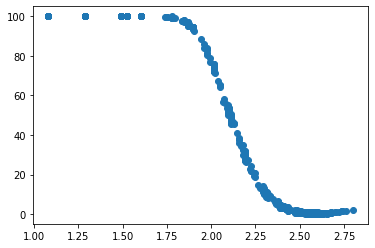

time: 190 ms (started: 2023-01-16 18:55:33 +00:00)


In [ ]:
plt.scatter(alpha_history, cost_history)

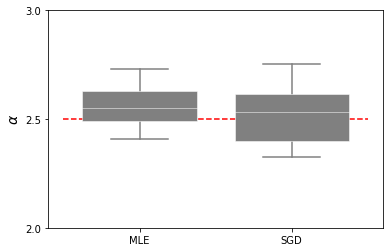

time: 138 ms (started: 2023-01-21 13:56:56 +00:00)


In [ ]:
# print(np.asarray(statistics_mle)[:,0])
# print(np.asarray(statistics_sgd)[:,0])

D = (np.asarray(statistics_mle)[:,0], np.asarray(statistics_sgd)[:,0])

# plot
fig, ax = plt.subplots()
bp1 = ax.boxplot(np.asarray(statistics_mle)[:,0], positions=[2], widths=1.5, patch_artist=True,
                showmeans=False, showfliers=False,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "gray", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "gray", "linewidth": 1.5},
                capprops={"color": "gray", "linewidth": 1.5})

bp2 = ax.boxplot(np.asarray(statistics_sgd)[:,0], positions=[4], widths=1.5, patch_artist=True,
                showmeans=False, showfliers=False,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "gray", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "gray", "linewidth": 1.5},
                capprops={"color": "gray", "linewidth": 1.5})

# ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['MLE', 'Ours'], loc='upper right')

ax.hlines(2.5, xmin=1, xmax=5, color='r', linestyles='--')

ax.set_xticklabels(['MLE', 'SGD'])
ax.set_ylabel(r'$\alpha$', fontsize=14)


ax.set(ylim=(2, 3), yticks=np.arange(1, 4, step=0.5))

plt.savefig('boxplot.pdf')

plt.show()

In [ ]:
mle_bias = []
sgd_bias = []
for i in range(10):
  print("\multirow{2}{*}{" + str(i+1) +"} ", end=' ')
  print("& MLE", end=' ')
  print("& %.3f" % statistics_mle[i][0], end=' ')
  bias = statistics_mle[i][0]-2.5
  mle_bias.append(bias)
  print("& %.3f" % bias, end=' ')

  for j in range(3, 7):
    print("& %.3f" % statistics_mle[i][j], end=' ')
  print("\\\ \cline{2-8}")

  ##########
  print("& SGD", end=' ')
  print("& %.3f" % statistics_sgd[i][0], end=' ')
  bias = statistics_sgd[i][0]-2.5
  sgd_bias.append(bias)
  print("& %.3f" % bias, end=' ')

  for j in range(3, 7):
    print("& %.3f" % statistics_sgd[i][j], end=' ')
  print("\\\ \hline \hline")


  # print(statistics_sgd[i])


\multirow{2}{*}{1}  & MLE & 2.615 & 0.115 & 99.560 & 0.260 & 5.365 & 0.393 \\ \cline{2-8}
& SGD & 2.560 & 0.060 & 99.520 & 0.330 & 3.532 & 0.398 \\ \hline \hline
\multirow{2}{*}{2}  & MLE & 2.565 & 0.065 & 99.600 & 0.460 & 5.527 & 0.379 \\ \cline{2-8}
& SGD & 2.540 & 0.040 & 99.720 & 0.510 & 6.023 & 0.381 \\ \hline \hline
\multirow{2}{*}{3}  & MLE & 2.724 & 0.224 & 98.440 & 0.530 & 34.350 & 0.423 \\ \cline{2-8}
& SGD & 2.753 & 0.253 & 98.640 & 0.550 & 36.746 & 0.421 \\ \hline \hline
\multirow{2}{*}{4}  & MLE & 2.729 & 0.229 & 97.800 & 0.180 & 0.525 & 0.279 \\ \cline{2-8}
& SGD & 2.635 & 0.135 & 98.400 & 0.300 & 1.586 & 0.294 \\ \hline \hline
\multirow{2}{*}{5}  & MLE & 2.469 & -0.031 & 96.080 & 0.230 & 1.179 & 0.306 \\ \cline{2-8}
& SGD & 2.353 & -0.147 & 97.760 & 0.310 & 4.425 & 0.327 \\ \hline \hline
\multirow{2}{*}{6}  & MLE & 2.489 & -0.011 & 99.640 & 0.280 & 1.069 & 0.363 \\ \cline{2-8}
& SGD & 2.522 & 0.022 & 99.720 & 0.230 & 1.053 & 0.361 \\ \hline \hline
\multirow{2}{*}{7}  & M

In [ ]:
def rmse(values, expected):
  rmse = np.sqrt(np.sum(np.power((np.asarray(values)-expected), 2)))
  return rmse

time: 907 µs (started: 2023-01-21 13:58:40 +00:00)


In [ ]:
print(np.mean(mle_bias), np.mean(np.abs(mle_bias)), rmse(mle_bias, 2.5))
print(np.mean(sgd_bias), np.mean(np.abs(sgd_bias)), rmse(sgd_bias, 2.5))


0.06647879731601951 0.09391751896346237 7.702251057433344
0.01607521708071342 0.11261939172101129 7.865722933591922
time: 2.18 ms (started: 2023-01-21 13:58:43 +00:00)


In [ ]:
print(statistics_mle)
print(statistics_sgd)


[(2.6151631534052706, 1.0, 0.9947407478869413, 99.56, 0.26, 5.365363281537144, 0.39314856781680935), (2.565288440548108, 1.0, 0.9970099258810605, 99.6, 0.46, 5.526904632835231, 0.37923747850220285), (2.724337855367362, 1.0, 0.9897311544511666, 98.44000000000001, 0.53, 34.35044993237477, 0.4228604751805788), (2.7288403796542773, 1.0, 0.9920459107482282, 97.8, 0.18, 0.525272964803176, 0.27873250796991283), (2.4692078795975476, 1.0, 0.9875744860717044, 96.08, 0.23, 1.1794598200426607, 0.30601598439086497), (2.4894105618187217, 1.0, 0.9975077136796286, 99.64, 0.28, 1.0693913535093973, 0.36337149630441135), (2.4099359745788638, 1.0, 0.9915248041914183, 98.4, 0.28, 7.1296690499024, 0.4008908150070426), (2.5341025457742212, 1.0, 0.9869743390784146, 95.04, 0.4, 5.969160885546537, 0.25855355967314597), (2.4942519757676527, 1.0, 0.9909055554712347, 98.83999999999999, 0.24, 3.2492634249168955, 0.34718946531388994), (2.63424920664817, 1.0, 0.9952116770841776, 99.36, 0.34, 2.487921096837943, 0.3568

## Estimating attribute distributions of empirical data

In [ ]:
# learning_rate = 0.05
# max_iterations = 100
# momentum=0.5
# n_seeds = 10

time: 779 µs (started: 2022-12-22 18:49:00 +00:00)


In [ ]:
def plot_evaluation(data, set_name):

  metric_results = []
  

  rosechart(data[:, 0], filename=set_name +'rosechart.pdf')

  print('Estimating alpha and xmin with SGD')
  metric='KS_t'
  alpha_sgd, x_min_sgd, cost_history, alpha_history, x_min_history = alpha_estimator(data[:, 1], max_iterations, learning_rate, n_seeds, fix_x_min=None, metric=metric)
  r2, ks_t, ks_d, A2, HD = powerlaw_fitting(data[:, 1], alpha_sgd, x_min_sgd, ks_evaluation=True, filename=set_name+'_sgd_'+metric+'.pdf')
  metric_results.append([alpha_sgd, x_min_sgd, r2, ks_t, ks_d, A2, HD])
  print((alpha_sgd, x_min_sgd, r2, ks_t, ks_d, A2, HD))

  print('Estimating alpha and xmin with Deluca2013/Corral2019')
  alpha_d, xmin_d = power_law_fitting_deluca(data[:, 1])
  r2, ks_t, ks_d, A2, HD = powerlaw_fitting(data[:, 1], alpha_d, xmin_d, ks_evaluation=True, filename=set_name+'_MLE_Deluca.pdf')
  metric_results.append([alpha_d, xmin_d, r2, ks_t, ks_d, A2, HD])
  print((alpha_d, xmin_d, r2, ks_t, ks_d, A2, HD))

  print('Estimating alpha and xmin with Clauset2009/Alstot2013')
  fit = powerlaw.Fit(set1[:, 1])
  alpha_mle = fit.power_law.alpha
  xmin_mle = fit.xmin
  r2, ks_t, ks_d, A2, HD = powerlaw_fitting(data[:, 1], alpha_mle, xmin_mle, ks_evaluation=True, filename=set_name+'_MLE_Clauset.pdf')
  metric_results.append([alpha_mle, xmin_mle, r2, ks_t, ks_d, A2, HD])
  print((alpha_mle, xmin_mle, r2, ks_t, ks_d, A2, HD))

  return metric_results


time: 4.09 ms (started: 2023-01-21 14:35:46 +00:00)


Estimating alpha and xmin with SGD


<ipython-input-10-f27ef2f619b0>:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  plot = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
<ipython-input-7-979a3af64391>:6: RuntimeWarning: invalid value encountered in power
  S = (uniform_data/np.min(uniform_data))**(-alpha+1)


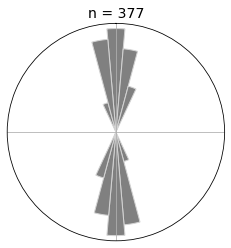

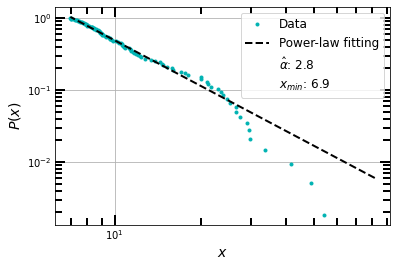

(2.750603928605292, 6.927118813127921, 0.9960165253862608, 99.76, 0.37, 3.3625538792355485, 0.2909132744459969)
Estimating alpha and xmin with Deluca2013/Corral2019
2.6217526221361576 4.7261603574995155


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


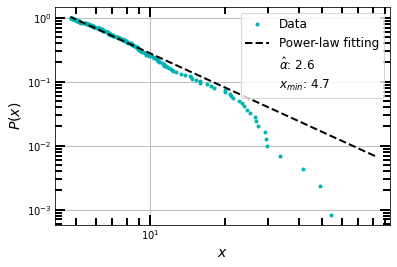

(2.6217526221361576, 4.7261603574995155, 0.9930929033754091, 97.36, 0.36363636363636365, 10.118862363952383, 0.27598649276096526)
Estimating alpha and xmin with Clauset2009/Alstot2013
Calculating best minimal value for power law fit


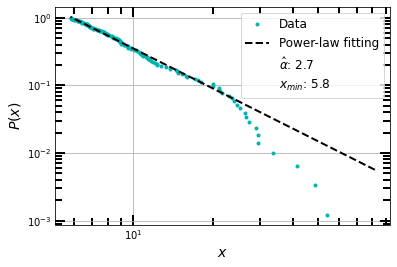

(2.734910947933339, 5.778112133525959, 0.9964225237172211, 99.6, 0.37037037037037035, 4.845310950682124, 0.2730803260912416)
time: 37min 48s (started: 2023-01-21 14:35:49 +00:00)


In [ ]:
# Set N-S (0-20 e 160 a 180) (?0)
set1 = np.where((segm_group_angles[:, 0] <= 20) | (segm_group_angles[:, 0] > 160) & (segm_group_angles[:, 1] > 0),
         segm_group_angles[:, 0], None)

set1 = segm_group_angles[set1 != np.array(None)]

# print(set1[:,1])

results_NS = plot_evaluation(set1, 'N_S_')

Estimating alpha and xmin with SGD


<ipython-input-10-f27ef2f619b0>:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  plot = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


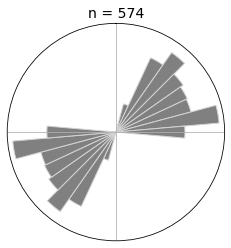

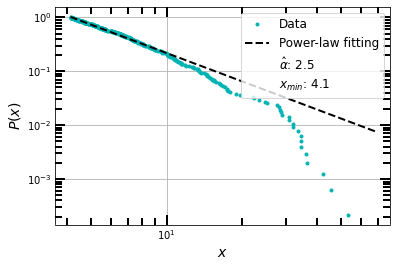

(2.516118570990013, 4.117948621179596, 0.9961477872120434, 98.88, 0.49404761904761907, 48.54871682833779, 0.23821399509663088)
Estimating alpha and xmin with Deluca2013/Corral2019
2.8103821166538845 6.380787695345619


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


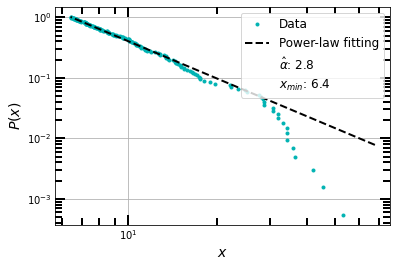

(2.8103821166538845, 6.380787695345619, 0.9980331911241115, 99.2, 0.37158469945355194, 13.861516028878881, 0.2408072491342658)
Estimating alpha and xmin with Clauset2009/Alstot2013
Calculating best minimal value for power law fit


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


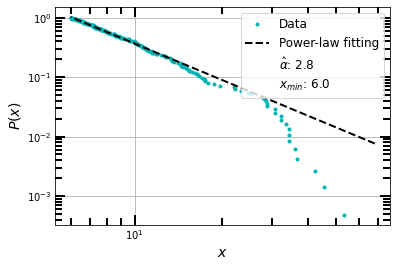

(2.7548014222275485, 5.9809815700852935, 0.9977132584954392, 99.0, 0.37185929648241206, 17.281618109836998, 0.20922646633628514)
time: 49min 41s (started: 2023-01-21 15:13:37 +00:00)


In [ ]:
# Set NE-SW (20 a 90)
set1 = np.where((segm_group_angles[:, 0] > 20) & (segm_group_angles[:, 0] <= 90) & (segm_group_angles[:, 1] >0),
         segm_group_angles[:, 0], None)

set1 = segm_group_angles[set1 != np.array(None)]

results_NE_SW = plot_evaluation(set1, 'NE_SW_')

Estimating alpha and xmin with SGD


<ipython-input-10-f27ef2f619b0>:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  plot = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


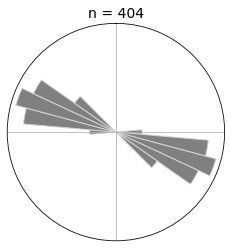

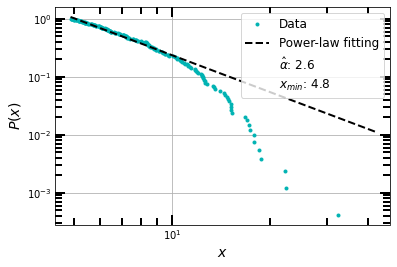

(2.6340694819872943, 4.842831179562177, 0.9874567142852605, 96.52, 0.6358695652173914, 47.21912571340906, 0.30130005015901157)
Estimating alpha and xmin with Deluca2013/Corral2019
3.3425681400262883 6.881493887325633


<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


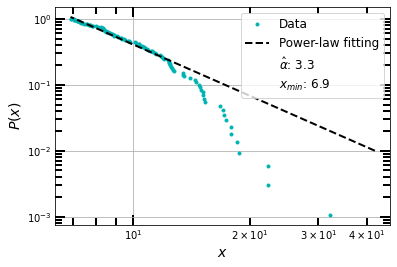

(3.3425681400262883, 6.881493887325633, 0.9827959239861696, 90.56, 0.44545454545454544, 8.597938686387403, 0.2480432598582501)
Estimating alpha and xmin with Clauset2009/Alstot2013
Calculating best minimal value for power law fit


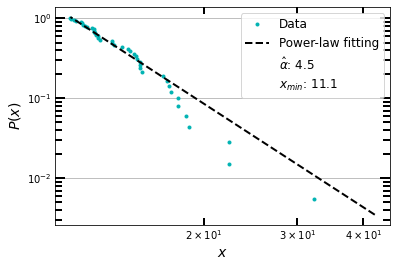

(4.540978111885373, 11.10459641815046, 0.9849656335340188, 99.32, 0.3023255813953488, 3.4965220046227734, 0.32088687360486084)
time: 37min 6s (started: 2023-01-21 16:03:19 +00:00)


In [ ]:
# Set ESE-WNW (90 a 130)
set1 = np.where((segm_group_angles[:, 0] > 90) & (segm_group_angles[:, 0] <= 130) & (segm_group_angles[:, 1] >0),
         segm_group_angles[:, 0], None)

set1 = segm_group_angles[set1 != np.array(None)]

results_ESE_WNN = plot_evaluation(set1, 'ESE_WNW_')


Estimating alpha and xmin with SGD


<ipython-input-10-f27ef2f619b0>:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  plot = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
<ipython-input-13-b692e9e0a81b>:76: UserWarning: p-value floored: true value smaller than 0.001
  A2 = anderson_ksamp([cdf(X), Y_], midrank=False)[0]


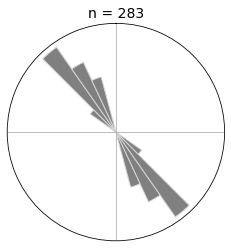

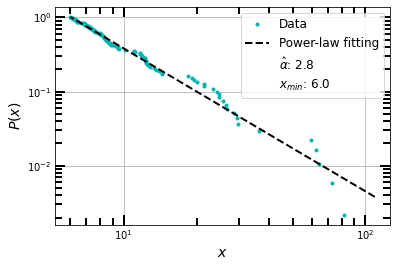

(2.791806145861984, 5.999722767023442, 0.9940577923941323, 99.11999999999999, 0.26785714285714285, 12.857674847223539, 0.3560658448046228)
Estimating alpha and xmin with Deluca2013/Corral2019
2.504451738427558 4.74623539765992


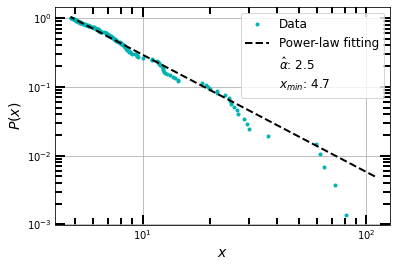

(2.504451738427558, 4.74623539765992, 0.9925284785909669, 98.32, 0.2702702702702703, 3.8185075799136263, 0.31854425766364325)
Estimating alpha and xmin with Clauset2009/Alstot2013
Calculating best minimal value for power law fit


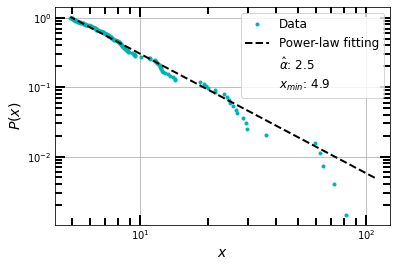

(2.534084975444216, 4.918275669378465, 0.9922823431390659, 97.76, 0.2727272727272727, 3.9613371562228727, 0.3200422733307672)
time: 27min 30s (started: 2023-01-21 16:40:26 +00:00)


In [ ]:
# Set SE-NO (130 a 160)
set1 = np.where((segm_group_angles[:, 0] > 130) & (segm_group_angles[:, 0] <= 160) & (segm_group_angles[:, 1] >0),
         segm_group_angles[:, 0], None)

set1 = segm_group_angles[set1 != np.array(None)]

results_SE_NO = plot_evaluation(set1, 'SE_NO_')


In [ ]:
def print_empirical_results(results, direction):
  print("\multirow{3}{*}{" + direction +"} ", end=' ')
  for i in [2,1,0]:
    
    if i == 0:
      print(r"& SGD" + "", end=' ')
    if i == 1:
      print(r"& MLE²" + "", end=' ')
    if i == 2:
      print(r"& MLE¹" + "", end=' ')
    for j in [0,1,3,4,5,6]:
      print("& %.3f" % results[i][j], end=' ')
    if i !=0:
      print("\\\ \cline{2-8}")
  print("\\\ \hline \hline")

print_empirical_results(results_NS, 'N-S')
print_empirical_results(results_NE_SW, 'NE-SW')
print_empirical_results(results_ESE_WNN, 'ESE-WNW')
print_empirical_results(results_SE_NO, 'SE-NO')

\multirow{3}{*}{N-S}  & MLE² & 2.735 & 5.778 & 99.600 & 0.370 & 4.845 & 0.273 \\ \cline{2-8}
& MLE¹ & 2.622 & 4.726 & 97.360 & 0.364 & 10.119 & 0.276 \\ \cline{2-8}
& SGD & 2.751 & 6.927 & 99.760 & 0.370 & 3.363 & 0.291 \\ \hline \hline
\multirow{3}{*}{NE-SW}  & MLE² & 2.755 & 5.981 & 99.000 & 0.372 & 17.282 & 0.209 \\ \cline{2-8}
& MLE¹ & 2.810 & 6.381 & 99.200 & 0.372 & 13.862 & 0.241 \\ \cline{2-8}
& SGD & 2.516 & 4.118 & 98.880 & 0.494 & 48.549 & 0.238 \\ \hline \hline
\multirow{3}{*}{ESE-WNN}  & MLE² & 4.541 & 11.105 & 99.320 & 0.302 & 3.497 & 0.321 \\ \cline{2-8}
& MLE¹ & 3.343 & 6.881 & 90.560 & 0.445 & 8.598 & 0.248 \\ \cline{2-8}
& SGD & 2.634 & 4.843 & 96.520 & 0.636 & 47.219 & 0.301 \\ \hline \hline
\multirow{3}{*}{SE-NO}  & MLE² & 2.534 & 4.918 & 97.760 & 0.273 & 3.961 & 0.320 \\ \cline{2-8}
& MLE¹ & 2.504 & 4.746 & 98.320 & 0.270 & 3.819 & 0.319 \\ \cline{2-8}
& SGD & 2.792 & 6.000 & 99.120 & 0.268 & 12.858 & 0.356 \\ \hline \hline
time: 46.3 ms (started: 2023-01-21 20:47:

In [ ]:
set1 = np.where((segm_group_angles[:, 0] > 90) & (segm_group_angles[:, 0] <= 130) & (segm_group_angles[:, 1] >0),
         segm_group_angles[:, 0], None)

set1 = segm_group_angles[set1 != np.array(None)]

time: 7.91 ms (started: 2023-01-21 21:07:52 +00:00)


In [ ]:
1-np.size(set1[set1[:,1]>11.105][:,0])/404

0.8935643564356436

time: 4.37 ms (started: 2023-01-21 21:15:00 +00:00)


In [ ]:
np.size(set1[:,0])

404

time: 3.83 ms (started: 2023-01-21 21:11:37 +00:00)
